In [1]:
# --- 1. Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
#!pip install xgboost prophet
from xgboost import XGBRegressor
from prophet import Prophet
from prophet.make_holidays import make_holidays_df


In [2]:
# --- 2. Load Data ---
xls = pd.ExcelFile("Buildings_el.xlsx")
electricity_df = xls.parse("Electricity kWh")
weather_df = xls.parse("Weather archive")

# --- 3. Clean Electricity Data ---
electricity_df.columns = electricity_df.iloc[0]
electricity_df = electricity_df[1:].copy()
electricity_df.rename(columns={electricity_df.columns[0]: "Timestamp"}, inplace=True)
electricity_df["Timestamp"] = pd.to_datetime(electricity_df["Timestamp"])
electricity_df.set_index("Timestamp", inplace=True)
electricity_df = electricity_df.apply(pd.to_numeric, errors='coerce')
electricity_df["Total_kWh"] = electricity_df.sum(axis=1)

# --- 4. Clean Weather Data ---
weather_df.columns = weather_df.iloc[1]
weather_df = weather_df[2:].copy()
weather_df.rename(columns={"Local time in Tallinn ": "Timestamp"}, inplace=True)
weather_df["Timestamp"] = pd.to_datetime(weather_df["Timestamp"], dayfirst=True)
weather_df = weather_df.rename(columns={"T": "Temperature", "U": "Humidity", "Ff": "Wind", "P0": "Pressure"})
for col in ["Temperature", "Humidity", "Wind", "Pressure"]:
    weather_df[col] = pd.to_numeric(weather_df[col], errors='coerce')
weather_df = weather_df[["Timestamp", "Temperature", "Humidity", "Wind", "Pressure"]].dropna()
weather_df = weather_df.set_index("Timestamp").resample("h").mean()

# --- 5. Merge Electricity + Weather ---
df = electricity_df.merge(weather_df, left_index=True, right_index=True, how="inner").copy()
df["Hour"] = df.index.hour
df["DayOfWeek"] = df.index.dayofweek
df["Month"] = df.index.month
df["IsWeekend"] = (df["DayOfWeek"] >= 5).astype(int)

df.head(n=50)

,ICT,"U06, U06A, U05B",OBS,"U05, U04, U04B, GEO",TEG,LIB,MEK,SOC,S01,D04,Total_kWh,Temperature,Humidity,Wind,Pressure,Hour,DayOfWeek,Month,IsWeekend
Timestamp,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,135.0,98.4,7.540,84.9,5,27.2,13.6,67.5,2.9,10.6,452.640,5.0,93.0,5.0,742.60,0,6,1,1
2023-01-01 01:00:00,134.7,96.4,7.299,85.8,6,27.0,13.7,67.2,2.9,12.3,453.299,5.0,90.0,5.0,742.95,1,6,1,1
2023-01-01 02:00:00,133.1,98.1,7.129,84.8,5,27.0,13.8,67.4,2.8,12.0,451.129,4.5,93.0,6.0,743.30,2,6,1,1
2023-01-01 03:00:00,129.9,96.3,7.258,84.9,6,26.2,13.7,67.3,2.8,10.9,445.258,4.0,93.0,6.0,744.10,3,6,1,1
2023-01-01 04:00:00,130.7,97.4,7.238,94.1,5,26.8,14.0,67.6,2.9,11.5,457.238,3.5,90.0,5.5,744.10,4,6,1,1
2023-01-01 05:00:00,130.3,96.8,7.201,95.8,5,25.9,13.7,67.6,2.9,11.4,456.601,2.5,93.0,3.0,744.45,5,6,1,1
2023-01-01 06:00:00,128.9,96.6,7.181,109.7,6,25.7,18.6,68.7,2.8,11.3,475.481,2.0,96.5,3.0,744.80,6,6,1,1
2023-01-01 07:00:00,132.3,95.6,7.146,89.3,5,25.7,20.4,68.9,2.8,11.4,458.546,2.0,93.0,3.0,744.80,7,6,1,1
2023-01-01 08:00:00,131.8,97.0,7.247,89.3,5,26.6,21.2,68.2,2.9,15.7,464.947,1.5,96.5,2.5,745.60,8,6,1,1


Baseline Naive MAPE: 6.80%


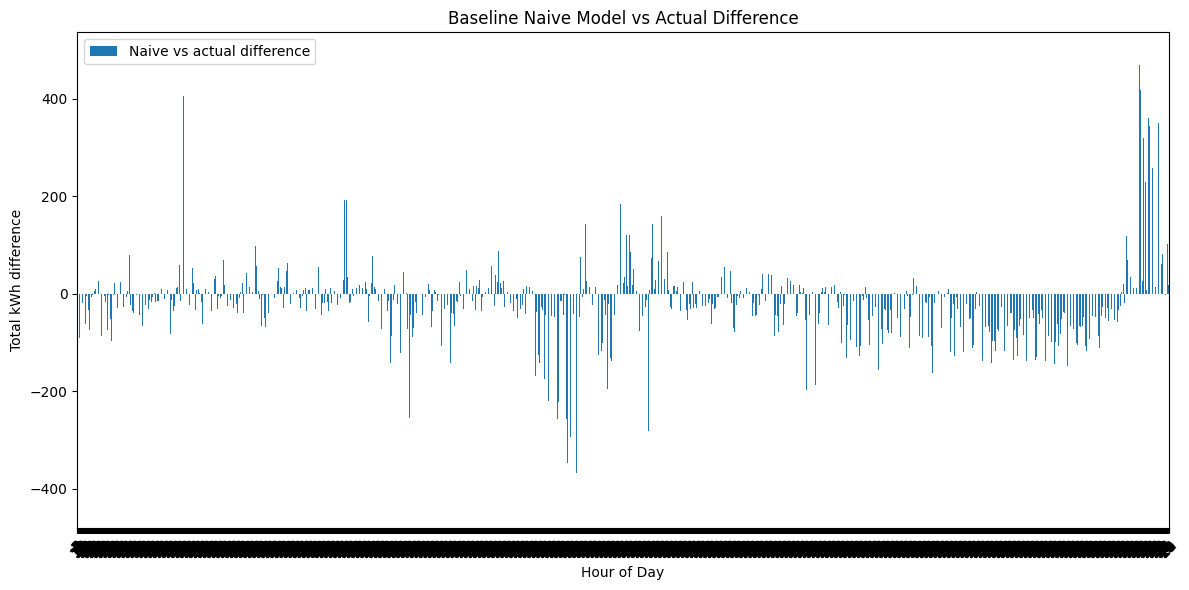

Description of X_test:


,Hour,DayOfWeek,Month,IsWeekend,Temperature,Humidity,Wind,Pressure
count,5806.000000,5806.000000,5806.000000,5806.000000,5803.000000,5803.000000,5803.000000,5803.000000
mean,11.502756,2.998967,7.042714,0.276610,7.259779,79.234362,3.981217,754.536524
std,6.922376,1.968485,3.374460,0.447361,9.343396,18.151854,2.061676,9.472123
min,0.000000,0.000000,2.000000,0.000000,-16.000000,20.000000,0.000000,722.200000
25%,6.000000,1.000000,5.000000,0.000000,-0.500000,69.500000,2.500000,748.500000
50%,12.000000,3.000000,8.000000,0.000000,6.500000,86.000000,4.000000,755.900000
75%,17.750000,5.000000,11.000000,1.000000,16.000000,93.000000,5.000000,761.325000
max,23.000000,6.000000,12.000000,1.000000,31.000000,100.000000,14.000000,771.950000


In [3]:
# --- 6. Define Training + Forecast Periods (Simulate 2 months known) ---
known_months = [1, 4, 7, 10]  # Example: Jan + Feb
train_df = df.loc[df.index.month.isin(known_months), :].copy()
test_df = df.loc[~df.index.month.isin(known_months), :].copy()

# --- 7. Baseline Model (Naive Hourly Average by Hour of Day and weekend vs weekday) ---
hourly_mean_by_weekday = train_df.groupby(["Hour", "IsWeekend"])["Total_kWh"].mean()

test_df["Naive_Pred"] = test_df[["Hour", "IsWeekend"]].apply(lambda x: hourly_mean_by_weekday[x["Hour"], x["IsWeekend"]], axis=1)


test_df["difference"] = test_df["Naive_Pred"] - test_df["Total_kWh"]
baseline_mape = mean_absolute_percentage_error(test_df["Total_kWh"], test_df["Naive_Pred"])
print(f"Baseline Naive MAPE: {baseline_mape:.2%}")

test_df.plot(x="Hour", y=["difference"], kind="bar", figsize=(12, 6), title="Baseline Naive Model vs Actual Difference")
plt.xticks(rotation=45)
plt.xlabel("Hour of Day")
plt.ylabel("Total kWh difference")
plt.legend(["Naive vs actual difference"])
plt.tight_layout()
plt.show()

# --- 8. XGBoost Forecasting ---
features = ["Hour", "DayOfWeek", "Month", "IsWeekend", "Temperature", "Humidity", "Wind", "Pressure"]
X_train = train_df[features]
y_train = train_df["Total_kWh"]
X_test = test_df[features]
y_test = test_df["Total_kWh"]

# print("Description of X_train:")
# X_train.describe()

print("Description of X_test:")
X_test.describe()

## Testing XGBoost with hour-level predictions and NO temporal variance features

XGBoost Forecast MAPE: 6.94%


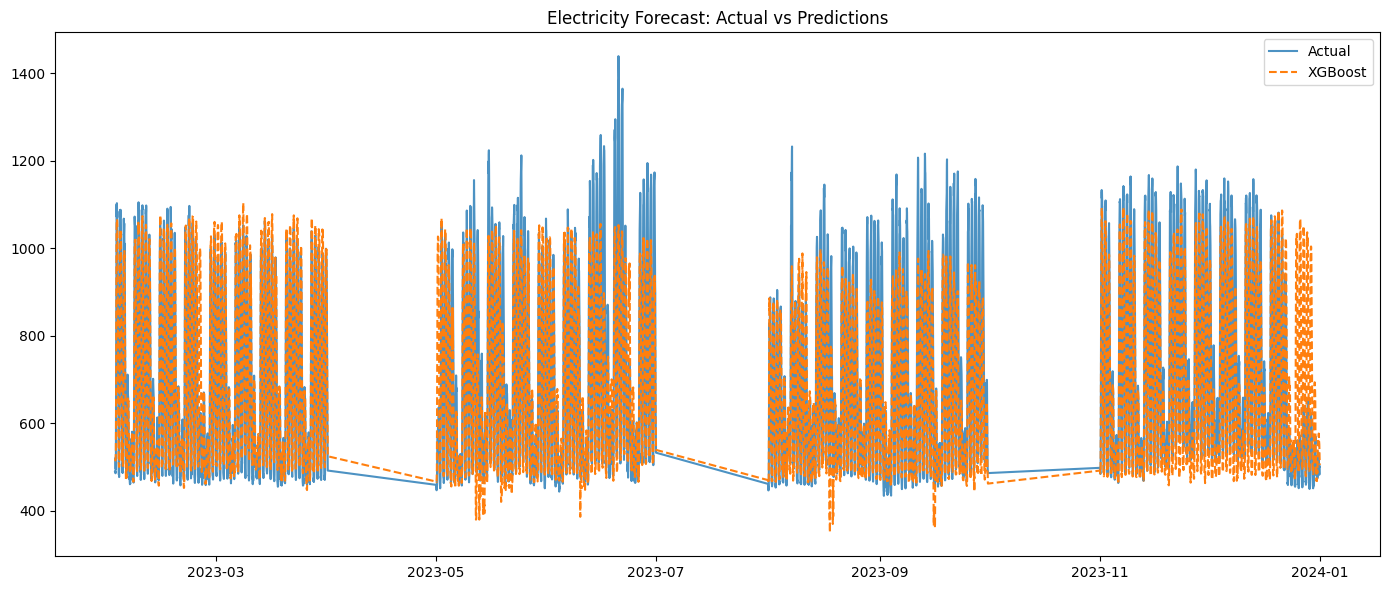

In [4]:
model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
model.fit(X_train, y_train)
test_df["XGB_Pred"] = model.predict(X_test)

xgb_mape = mean_absolute_percentage_error(y_test, test_df["XGB_Pred"])
print(f"XGBoost Forecast MAPE: {xgb_mape:.2%}")


# --- 10. Plot Predictions ---
plt.figure(figsize=(14, 6))
plt.plot(test_df.index, test_df["Total_kWh"], label="Actual", alpha=0.8)
plt.plot(test_df.index, test_df["XGB_Pred"], label="XGBoost", linestyle="--")
# plt.plot(test_df.index, test_df["Prophet_Pred"], label="Prophet", linestyle="--")
plt.legend()
plt.title("Electricity Forecast: Actual vs Predictions")
plt.tight_layout()
plt.show()

## Testing XGBoost with predictions at HOUR level, but input at PAST-6h level

In [5]:
# create X_train_6h starting from train_df. Apart from the hour level features, include some statistics of the last 6 hours for:
# Total_kWh, Temperature, Humidity, Wind, Pressure
# The statistics should be the mean, min, max, std, 25th percentile, 75th percentile
def percentile_25(x):
    return x.quantile(0.25)

def percentile_75(x):
    return x.quantile(0.75)

def create_rolling_features(df, hours=6):    
    rolling_features = df[["Total_kWh", "Temperature", "Humidity", "Wind", "Pressure"]].rolling(window=hours).agg([
        "mean", "min", "max", "std", percentile_25, percentile_75, "kurt", "skew"
    ])
    rolling_features.columns = [f"{col}_{stat}" for col, stat in rolling_features.columns]
    return rolling_features 

def create_df_with_rolling_features(df, hours=6):
    rolling_features = create_rolling_features(df, hours)
    rolling_features = rolling_features.shift(1)  # Shift to avoid data leakage
    df_with_rolling_features = pd.concat([df, rolling_features], axis=1)
    df_with_rolling_features.dropna(inplace=True)

    return df_with_rolling_features, rolling_features

df_with_6h_agg, rolling_features = create_df_with_rolling_features(df, hours=6)
# split into train and test sets
train_df_6h = df_with_6h_agg.loc[df_with_6h_agg.index.month.isin(known_months), :].copy()
test_df_6h = df_with_6h_agg.loc[~df_with_6h_agg.index.month.isin(known_months), :].copy()

# create X_train_6h starting from train_df. Apart from the hour level features, include those for the statistics of the last 6 hours
list_of_features = ["Hour", "DayOfWeek", "Month", "IsWeekend", "Temperature", "Humidity", "Wind", "Pressure"]
for col in rolling_features.columns:
    list_of_features.append(col)
    
X_train_6h = train_df_6h[list_of_features]
y_train_6h = train_df_6h["Total_kWh"]
X_test_6h = test_df_6h[list_of_features]
y_test_6h = test_df_6h["Total_kWh"]


In [6]:
X_train_6h.describe()

,Hour,DayOfWeek,Month,IsWeekend,Temperature,Humidity,Wind,Pressure,Total_kWh_mean,Total_kWh_min,...,Wind_kurt,Wind_skew,Pressure_mean,Pressure_min,Pressure_max,Pressure_std,Pressure_percentile_25,Pressure_percentile_75,Pressure_kurt,Pressure_skew
count,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,...,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000
mean,11.515439,3.019342,5.522905,0.307771,6.794706,78.215643,4.492365,754.036461,676.410724,589.260284,...,-0.108790,0.042944,754.043872,753.382576,754.689362,0.520055,753.721738,754.371013,-0.075865,-0.059553
std,6.918644,2.068243,3.363233,0.461649,7.672176,16.852674,2.184589,8.861983,191.182473,164.584049,...,1.939004,0.880461,8.819320,9.047553,8.620035,0.499317,8.938771,8.720842,2.802383,1.123891
min,0.000000,0.000000,1.000000,0.000000,-14.000000,20.500000,0.000000,727.700000,439.271500,425.374000,...,-3.333333,-2.449490,728.166667,727.700000,728.400000,0.000000,728.050000,728.400000,-3.333335,-2.449490
25%,6.000000,1.000000,1.000000,0.000000,1.000000,68.000000,3.000000,748.450000,510.626250,474.712500,...,-1.549587,-0.492807,748.425000,748.000000,748.800000,0.265832,748.100000,748.700000,-1.875000,-0.563885
50%,12.000000,3.000000,7.000000,0.000000,6.000000,83.000000,4.000000,754.000000,604.227667,502.120000,...,-0.300000,0.000000,753.966667,753.300000,754.500000,0.393277,753.800000,754.237500,-1.081652,0.000000
75%,18.000000,5.000000,10.000000,1.000000,13.000000,93.000000,6.000000,759.200000,834.507833,660.470500,...,0.851049,0.665669,759.216667,758.450000,759.700000,0.641255,759.000000,759.525000,1.239943,0.455939
max,23.000000,6.000000,10.000000,1.000000,27.500000,100.000000,16.000000,776.000000,1138.461000,1114.755000,...,6.000000,2.449490,776.000000,776.000000,776.000000,4.828354,776.000000,776.000000,6.000338,2.449490


XGBoost Forecast with 6h Aggregation MAPE: 2.69%


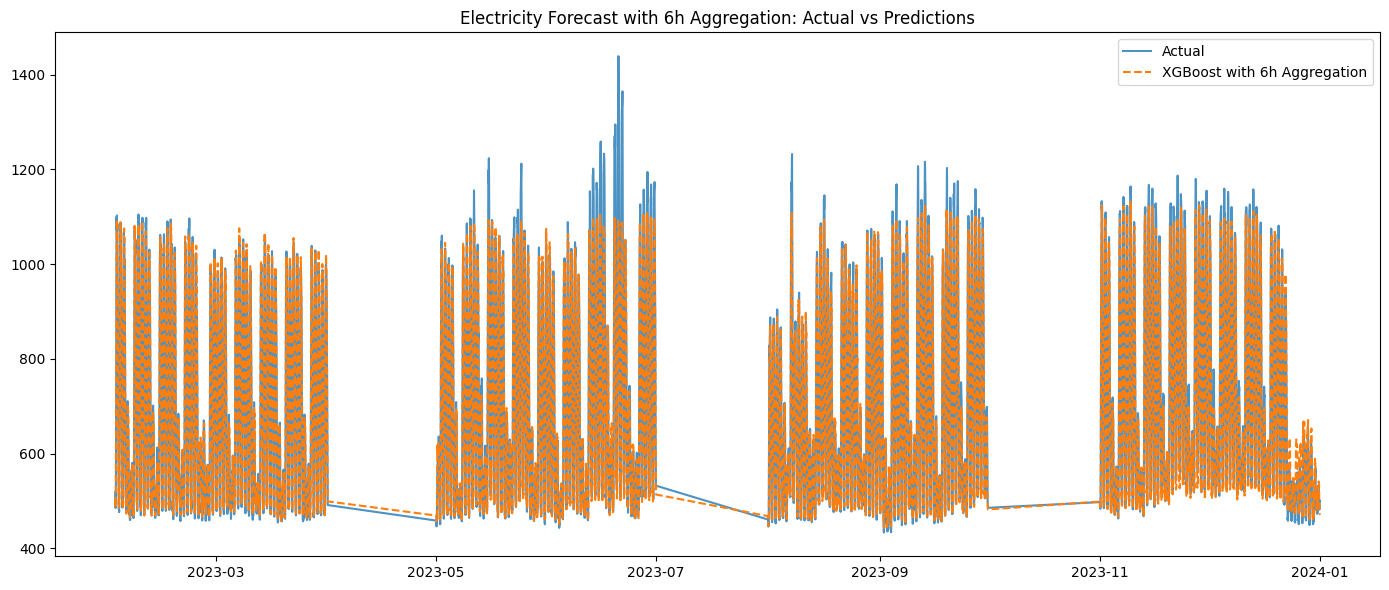

In [7]:
## Train the model on the new features
model_6h = XGBRegressor(n_estimators=100, max_depth=8, learning_rate=0.08, subsample=0.8, tree_method="auto", objective="reg:gamma", colsample_bytree=1)
model_6h.fit(X_train_6h, y_train_6h)
test_df_6h["XGB_Pred_6h"] = model_6h.predict(X_test_6h)
xgb_mape_6h = mean_absolute_percentage_error(y_test_6h, test_df_6h["XGB_Pred_6h"])
print(f"XGBoost Forecast with 6h Aggregation MAPE: {xgb_mape_6h:.2%}")
# --- 11. Plot Predictions with 6h Aggregation ---
plt.figure(figsize=(14, 6))
plt.plot(test_df_6h.index, test_df_6h["Total_kWh"], label="Actual", alpha=0.8)
plt.plot(test_df_6h.index, test_df_6h["XGB_Pred_6h"], label="XGBoost with 6h Aggregation", linestyle="--")
plt.legend()
plt.title("Electricity Forecast with 6h Aggregation: Actual vs Predictions")
plt.tight_layout()
plt.show()

## Testing Testing XGBoost with predictions at HOUR level, but input at PAST-12h level

In [8]:
df_with_12h_agg, rolling_features_12h = create_df_with_rolling_features(df, hours=12)
# split into train and test sets
train_df_12h = df_with_12h_agg.loc[df_with_12h_agg.index.month.isin(known_months), :].copy()
test_df_12h = df_with_12h_agg.loc[~df_with_12h_agg.index.month.isin(known_months), :].copy()
# create X_train_12h starting from train_df. Apart from the hour level features, include those for the statistics of the last 12 hours
list_of_features_12h = ["Hour", "DayOfWeek", "Month", "IsWeekend", "Temperature", "Humidity", "Wind", "Pressure"]
for col in rolling_features_12h.columns:
    list_of_features_12h.append(col)
X_train_12h = train_df_12h[list_of_features_12h]
y_train_12h = train_df_12h["Total_kWh"]
X_test_12h = test_df_12h[list_of_features_12h]
y_test_12h = test_df_12h["Total_kWh"]

XGBoost Forecast with 12h Aggregation MAPE: 3.08%


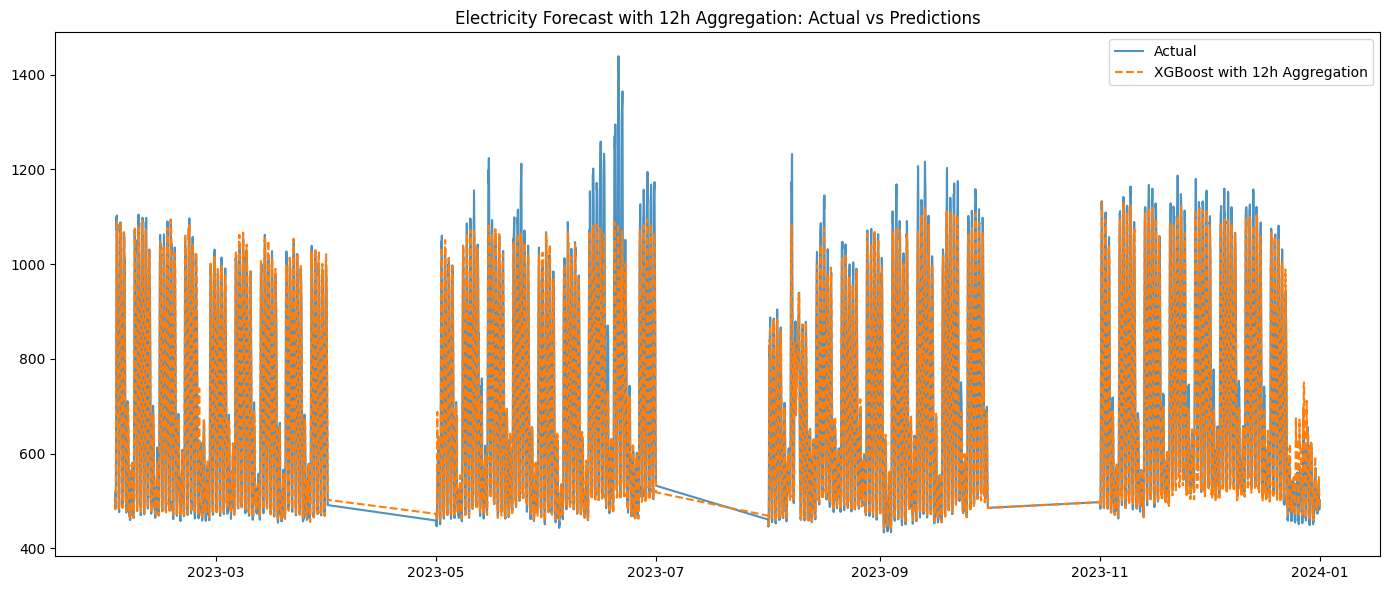

In [9]:
# Train the model on the new features
model_12h = XGBRegressor(n_estimators=200, max_depth=10, learning_rate=0.05, subsample=0.75, tree_method="auto", objective="reg:gamma", colsample_bytree=1)
model_12h.fit(X_train_12h, y_train_12h)
test_df_12h["XGB_Pred_12h"] = model_12h.predict(X_test_12h)
xgb_mape_12h = mean_absolute_percentage_error(y_test_12h, test_df_12h["XGB_Pred_12h"])
print(f"XGBoost Forecast with 12h Aggregation MAPE: {xgb_mape_12h:.2%}")
# --- 12. Plot Predictions with 12h Aggregation ---
plt.figure(figsize=(14, 6))
plt.plot(test_df_12h.index, test_df_12h["Total_kWh"], label="Actual", alpha=0.8)
plt.plot(test_df_12h.index, test_df_12h["XGB_Pred_12h"], label="XGBoost with 12h Aggregation", linestyle="--")
plt.legend()
plt.title("Electricity Forecast with 12h Aggregation: Actual vs Predictions")
plt.tight_layout()
plt.show()

## Testing FB Prophet on hour level predictions and 6h input

22:07:40 - cmdstanpy - INFO - Chain [1] start processing
22:07:41 - cmdstanpy - INFO - Chain [1] done processing


Prophet Forecast MAPE: 12.73%


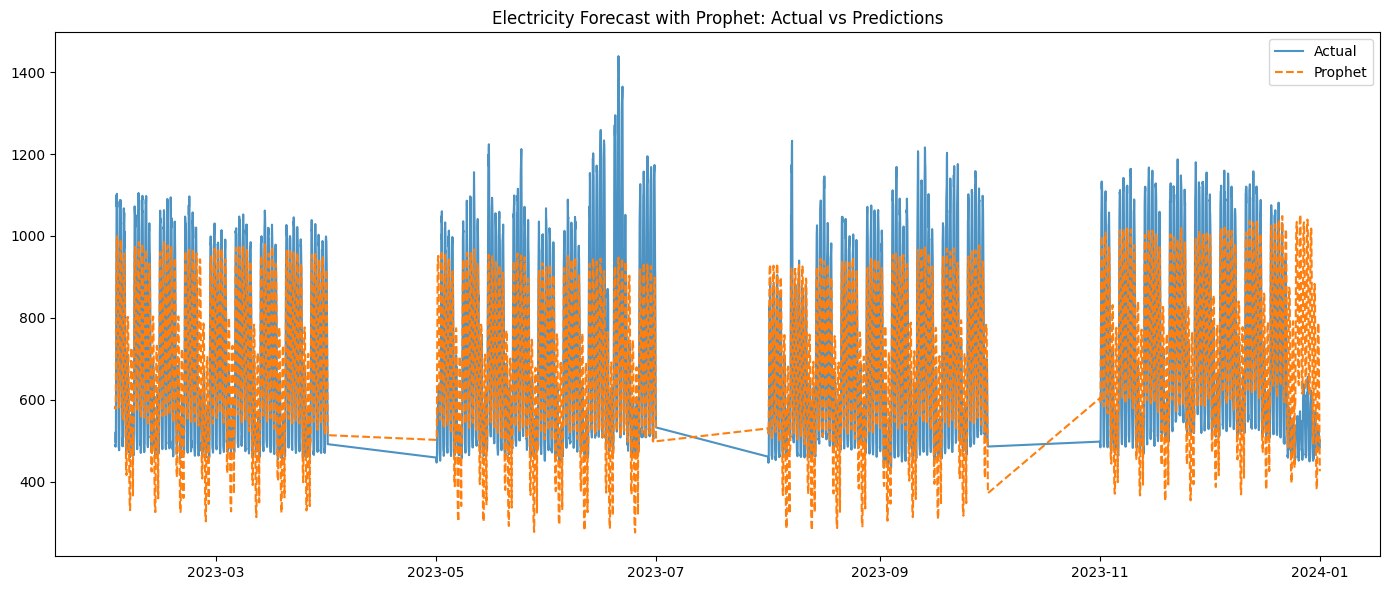

In [10]:
# --- Prophet Forecasting ---
prophet_df = train_df.reset_index().rename(columns={"Timestamp": "ds", "Total_kWh": "y"})
estonia_holidays = make_holidays_df(year_list=[2023], country="EE")

prophet = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False, holidays=estonia_holidays)
prophet.add_seasonality(name="daily", period=12, fourier_order=8, prior_scale=10)

## add all the features as regressors to the prophet model
feature_cols = ["Temperature", "Humidity", "Wind", "Pressure", "Month", "Hour", "DayOfWeek", "IsWeekend"]
for col in feature_cols:
    prophet.add_regressor(col)

## impute in Temperature, Humidity, Wind, Pressure using the mean of the preceding and following 2 hours
for col in ["Temperature", "Humidity", "Wind", "Pressure"]:
    prophet_df[col] = prophet_df[col].interpolate(method="linear", limit_direction="both")

prophet.fit(prophet_df)

prophet_test_df = test_df.reset_index().rename(columns={"Timestamp": "ds"})
## impute Temperature, Humidity, Wind, Pressure using the mean of the preceding and following 2 hours for the test set
for col in ["Temperature", "Humidity", "Wind", "Pressure"]:
    prophet_test_df[col] = prophet_test_df[col].interpolate(method="linear", limit_direction="both")

forecast = prophet.predict(prophet_test_df)
forecast_predictions = forecast[["ds", "yhat"]]
merged_test_df = prophet_test_df.merge(forecast_predictions, on="ds", how="left")

prophet_mape = mean_absolute_percentage_error(merged_test_df["Total_kWh"], merged_test_df["yhat"])
print(f"Prophet Forecast MAPE: {prophet_mape:.2%}")

# --- 13. Plot Predictions with Prophet ---
plt.figure(figsize=(14, 6))
plt.plot(merged_test_df["ds"], merged_test_df["Total_kWh"], label="Actual", alpha=0.8)
plt.plot(merged_test_df["ds"], merged_test_df["yhat"], label="Prophet", linestyle="--")
plt.legend()
plt.title("Electricity Forecast with Prophet: Actual vs Predictions")
plt.tight_layout()
plt.show()

C:\Users\S11\AppData\Local\Temp\ipykernel_13064\2023908709.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_target_df["XGB_CrossBuilding_Pred"] = model.predict(X_test)


Cross-Building XGBoost MAPE: 16.04%


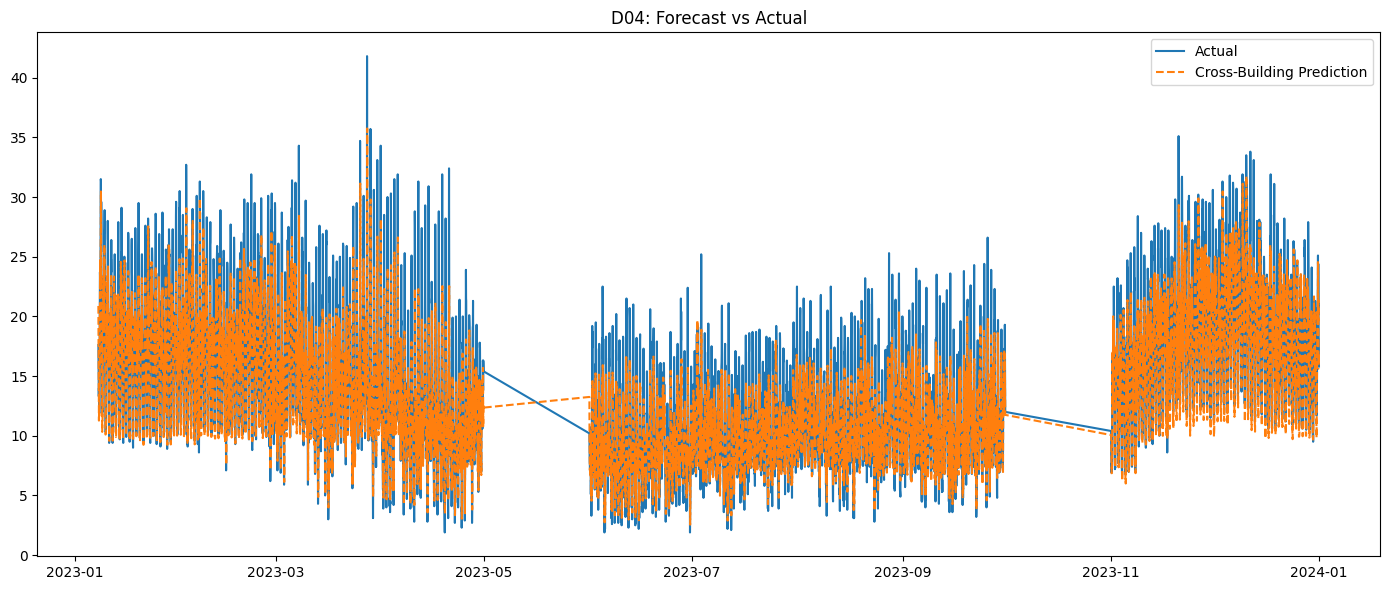

In [14]:
# --- Cross-Building Preparation ---
target_building = "D04"  # <-- change this to your test building
all_buildings = [col for col in electricity_df.columns if col != "Total_kWh"]

building_sizes = {
    "ICT": 11413,
    "MEK": 4434,
    "SOC": 10360,
    "S01": 5302,
    "D04": 4323.6,
    "U06": 15413,
    "U06A": 15413,
    "U05B": 15413,
    "U05": 13654,
    "U04":  13654,
    "U04B": 13654,
    "GEO":  13654,
    "LIB": 11062,
    "TEG": 1968.1,
}



# Store all training data from other buildings
cross_building_data = []

for df in cross_building_data:
    b = df["Building"].iloc[0]
    df["Building_Size"] = building_sizes.get(b, 1000)


cross_building_data = []

for b in all_buildings:
    if b == target_building:
        continue
    b_df = electricity_df[[b]].rename(columns={b: "Total_kWh"})
    b_df = b_df.merge(weather_df, left_index=True, right_index=True, how="inner").copy()
    b_df["Hour"] = b_df.index.hour
    b_df["DayOfWeek"] = b_df.index.dayofweek
    b_df["Month"] = b_df.index.month
    b_df["IsWeekend"] = (b_df["DayOfWeek"] >= 5).astype(int)
    b_df["kWh_lag_1"] = b_df["Total_kWh"].shift(1)
    b_df["kWh_rolling_mean_24"] = b_df["Total_kWh"].shift(1).rolling(24).mean()
    b_df["kWh_rolling_std_24"] = b_df["Total_kWh"].shift(1).rolling(24).std()
    b_df["kWh_rolling_mean_168"] = b_df["Total_kWh"].shift(1).rolling(168).mean()
    b_df["Building"] = b
    b_df["Building_Size"] = building_sizes.get(b, 1000)  # <-- Adaugă aici!
    b_df = b_df.dropna()
    cross_building_data.append(b_df)

# Concatenate all buildings' data
train_all_buildings_df = pd.concat(cross_building_data, axis=0)

# --- New Building Data (Target) ---
target_df = electricity_df[[target_building]].rename(columns={target_building: "Total_kWh"})
target_df = target_df.merge(weather_df, left_index=True, right_index=True, how="inner").copy()
target_df["Hour"] = target_df.index.hour
target_df["DayOfWeek"] = target_df.index.dayofweek
target_df["Month"] = target_df.index.month
target_df["IsWeekend"] = (target_df["DayOfWeek"] >= 5).astype(int)
target_df["kWh_lag_1"] = target_df["Total_kWh"].shift(1)
target_df["kWh_rolling_mean_24"] = target_df["Total_kWh"].shift(1).rolling(24).mean()
target_df["kWh_rolling_std_24"] = target_df["Total_kWh"].shift(1).rolling(24).std()
target_df["kWh_rolling_mean_168"] = target_df["Total_kWh"].shift(1).rolling(168).mean()
target_df["Building_Size"] = building_sizes.get(target_building, 1000)
target_df = target_df.dropna()

# --- Split into known and unknown months ---
known_months = [5, 10]  # Replace with provided 2 months
train_target_df = target_df[target_df.index.month.isin(known_months)]
test_target_df = target_df[~target_df.index.month.isin(known_months)]

features = [
    "Hour", "DayOfWeek", "Month", "IsWeekend",
    "Temperature", "Wind", "Pressure",
    "kWh_lag_1", "kWh_rolling_mean_24", "kWh_rolling_std_24", "kWh_rolling_mean_168","Building_Size",
]

X_train = train_all_buildings_df[features]
y_train = train_all_buildings_df["Total_kWh"]

X_test = test_target_df[features]
y_test = test_target_df["Total_kWh"]

model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
model.fit(X_train, y_train)

test_target_df["XGB_CrossBuilding_Pred"] = model.predict(X_test)
mape_cross = mean_absolute_percentage_error(y_test, test_target_df["XGB_CrossBuilding_Pred"])
print(f"Cross-Building XGBoost MAPE: {mape_cross:.2%}")


plt.figure(figsize=(14, 6))
plt.plot(test_target_df.index, y_test, label="Actual")
plt.plot(test_target_df.index, test_target_df["XGB_CrossBuilding_Pred"], label="Cross-Building Prediction", linestyle="--")
plt.title(f"{target_building}: Forecast vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

